# Getting started with PPO and ProcGen

Here's a bit of code that should help you get started on your projects.

The cell below installs `procgen` and downloads a small `utils.py` script that contains some utility functions. You may want to inspect the file for more details.

In [ ]:
!pip install procgen
!wget https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py

     |████████████████████████████████| 39.9MB 1.2MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 22.2MB 1.5MB/s 
     |████████████████████████████████| 3.3MB 56.7MB/s 
     |████████████████████████████████| 204kB 43.4MB/s 
     |████████████████████████████████| 665kB 51.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
--2020-12-29 00:16:45--  https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14807 (14K) [text/plain]
Saving to: ‘utils.py

Hyperparameters. These values should be a good starting point. You can modify them later once you have a working implementation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import make_env, Storage, orthogonal_init
import numpy as np

# Hyperparameters
total_steps = 10e6
num_envs = 32
num_levels = 1000
num_steps = 256
num_epochs = 3
batch_size = 512
eps = .2
grad_eps = .5
value_coef = .5
entropy_coef = .01

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class Encoder(nn.Module):
  def __init__(self, in_channels, feature_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4), nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1), nn.ReLU(),
        Flatten(),
        nn.Linear(in_features=1024, out_features=feature_dim), nn.ReLU()
    )
    self.apply(orthogonal_init)

  def forward(self, x):
    return self.layers(x)


class Policy(nn.Module):
  def __init__(self, encoder, feature_dim, num_actions):
    super().__init__()
    self.encoder = encoder
    self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
    self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

  def act(self, x):
    with torch.no_grad():
      x = x.cuda().contiguous()
      dist, value = self.forward(x)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    
    return action.cpu(), log_prob.cpu(), value.cpu()

  def forward(self, x):
    x = self.encoder(x)
    logits = self.policy(x)
    value = self.value(x).squeeze(1)
    dist = torch.distributions.Categorical(logits=logits)

    return dist, value

Network definitions. We have defined a policy network for you in advance. It uses the popular `NatureDQN` encoder architecture (see below), while policy and value functions are linear projections from the encodings. There is plenty of opportunity to experiment with architectures, so feel free to do that! Perhaps implement the `Impala` encoder from [this paper](https://arxiv.org/pdf/1802.01561.pdf) (perhaps minus the LSTM).

In [ ]:
# Define environmentbossfight
# check the utils.py file for info on arguments
env = make_env(num_envs, num_levels=num_levels, env_name='starpilot', use_backgrounds=True)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space.n)

# Define network
encoder = Encoder(3,512)
policy = Policy(encoder, 512, 15)
policy.cuda()

# Define optimizer
# these are reasonable values but probably not optimal
optimizer = torch.optim.Adam(policy.parameters(), lr=5e-4, eps=1e-5)

# Define temporary storage
# we use this to collect transitions during each iteration
storage = Storage(
    env.observation_space.shape,
    num_steps,
    num_envs
)


# Run training
obs = env.reset()
step = 0
i=0
data=[];
print("NN setup, Training Starts")
while step < total_steps:

  # Use policy to collect data for num_steps steps
  policy.eval()
  for _ in range(num_steps):
    # Use policy
    action, log_prob, value = policy.act(obs)
    
    # Take step in environment
    next_obs, reward, done, info = env.step(action)

    # Store data
    storage.store(obs, action, reward, done, info, log_prob, value)
    
    # Update current observation
    obs = next_obs

  # Add the last observation to collected data
  _, _, value = policy.act(obs)
  storage.store_last(obs, value)

  # Compute return and advantage
  storage.compute_return_advantage()

  # Optimize policy
  policy.train()
  for epoch in range(num_epochs):

    # Iterate over batches of transitions
    generator = storage.get_generator(batch_size)
    for batch in generator:
      b_obs, b_action, b_log_prob, b_value, b_returns, b_advantage = batch

      # Get current policy outputs
      new_dist, new_value = policy(b_obs)
      new_log_prob = new_dist.log_prob(b_action)
      # log_prob
      # Clipped policy objective
      #print(str(log_prob.shape) + " " + str(b_log_prob.shape) + " " + str(new_log_prob.shape))
      ratio = torch.exp(new_log_prob - b_log_prob)
      
      clipped_ratio = ratio.clamp(min=1.0 - eps, max=1.0 + eps) 
      policy_reward = torch.min(ratio * b_advantage, clipped_ratio * b_advantage)
      #clip_fraction = (abs((ratio - 1.0)) > clip).to(torch.float).mean()
      pi_loss = -policy_reward.mean()

      # Clipped value function objective
      
      # vf_loss=torch.max((b_value-b_returns)**2, (clipped_value-b_returns)**2)
      # value_loss = 0.5 * vf_loss.mean()

      clipped_value = (b_value - new_value).clamp(min=-eps,max=eps)
      # clipped_value = b_value + (new_value - b_value).clamp(min=-eps,max=eps) #
      # vf_loss=torch.max((new_value-b_returns)**2, (clipped_value-b_returns)**2) #
      # value_loss = 0.5 * vf_loss.mean() #
      #clipped_value = (new_value - b_value).clamp(min=-eps,max=eps)
      value_loss = 0.5 * (torch.max(torch.pow(new_value - b_returns,2), torch.pow(b_value - b_returns, 2)).mean())

      # Entropy loss
      entropy_loss = new_dist.entropy().mean()

      # Backpropagate losses
      # loss = torch.mean(pi_loss+value_coef*value_loss+entropy_coef*entropy_loss) #
      loss = pi_loss + value_coef * value_loss - entropy_coef * entropy_loss
      loss.backward()

      # Clip gradients
      torch.nn.utils.clip_grad_norm_(policy.parameters(), grad_eps)

      # Update policy
      optimizer.step()
      optimizer.zero_grad()

  # Update stats
  step += num_envs * num_steps
  print(f'Step: {step}\tMean reward: {storage.get_reward()}')
  data.append(storage.get_reward())
  if step%1007616==0:
    torch.save(policy.state_dict(), 'checkpoint'+str(i)+'.pt')
    i=i+1

print('Completed training!')
torch.save(policy.state_dict(), 'checkpointFinal.pt')
np.save("data.npy",data)

Observation space: Box(0.0, 1.0, (3, 64, 64), float32)
Action space: 15
NN setup, Training Starts
Step: 8192	Mean reward: 3.90625
Step: 16384	Mean reward: 4.875
Step: 24576	Mean reward: 5.3125
Step: 32768	Mean reward: 5.15625
Step: 40960	Mean reward: 5.28125
Step: 49152	Mean reward: 6.78125
Step: 57344	Mean reward: 5.75
Step: 65536	Mean reward: 5.65625
Step: 73728	Mean reward: 5.5625
Step: 81920	Mean reward: 6.5
Step: 90112	Mean reward: 5.9375
Step: 98304	Mean reward: 6.0625
Step: 106496	Mean reward: 5.28125
Step: 114688	Mean reward: 6.34375
Step: 122880	Mean reward: 6.15625
Step: 131072	Mean reward: 6.4375
Step: 139264	Mean reward: 6.40625
Step: 147456	Mean reward: 6.0625
Step: 155648	Mean reward: 7.03125
Step: 163840	Mean reward: 6.65625
Step: 172032	Mean reward: 6.59375
Step: 180224	Mean reward: 6.1875
Step: 188416	Mean reward: 6.8125
Step: 196608	Mean reward: 6.59375
Step: 204800	Mean reward: 6.71875
Step: 212992	Mean reward: 6.4375
Step: 221184	Mean reward: 6.5625
Step: 229376	Mea

Below cell can be used for policy evaluation and saves an episode to mp4 for you to view.

**Generate video**

In [ ]:
import imageio

# Make evaluation environment
eval_env = make_env(num_envs, env_name = 'starpilot',start_level=num_levels, num_levels=num_levels, use_backgrounds=True)
obs = eval_env.reset()
policy.load_state_dict(torch.load(str("checkpointFinal.pt")))
policy.cuda()
frames = []
total_reward = []

# Evaluate policy
policy.eval()
for _ in range(512):

  # Use policy
  action, log_prob, value = policy.act(obs)

  # Take step in environment
  obs, reward, done, info = eval_env.step(action)
  total_reward.append(torch.Tensor(reward))

  # Render environment and store
  frame = (torch.Tensor(eval_env.render(mode='rgb_array'))*255.).byte()
  frames.append(frame)

# Calculate average return
total_reward = torch.stack(total_reward).sum(0).mean(0)
print('Average return:', total_reward)

# Save frames as video
frames = torch.stack(frames)
imageio.mimsave('vid.mp4', frames, fps=25)

Average return: tensor(14.9279)


**Generate video until the agent dies n times**

In [ ]:
import imageio
# Make evaluation environment
eval_env = make_env(1, env_name = 'starpilot',start_level=num_levels, num_levels=num_levels)
obs = eval_env.reset()
policy.load_state_dict(torch.load(str("checkpoint9.pt")))
policy.cuda()
frames = []
total_reward = []

# Evaluate policy
policy.eval()
for i in range(5):
  doneLoop=False
  while (doneLoop == False):

    # Use policy
    action, log_prob, value = policy.act(obs)

    # Take step in environment
    obs, reward, done, info = eval_env.step(action)
    #if(info["terminal_observation"].any() == True):
    if(done.any() == True):
      doneLoop= True
    total_reward.append(torch.Tensor(reward))

    # Render environment and store
    frame = (torch.Tensor(eval_env.render(mode='rgb_array'))*255.).byte()
    frames.append(frame)

# Calculate average return
total_reward = torch.stack(total_reward).sum(0).mean(0)
print('Average return:', total_reward)

# Save frames as video
frames = torch.stack(frames)
imageio.mimsave('vid.mp4', frames, fps=25)

Average return: tensor(38.7464)


**Plot training**

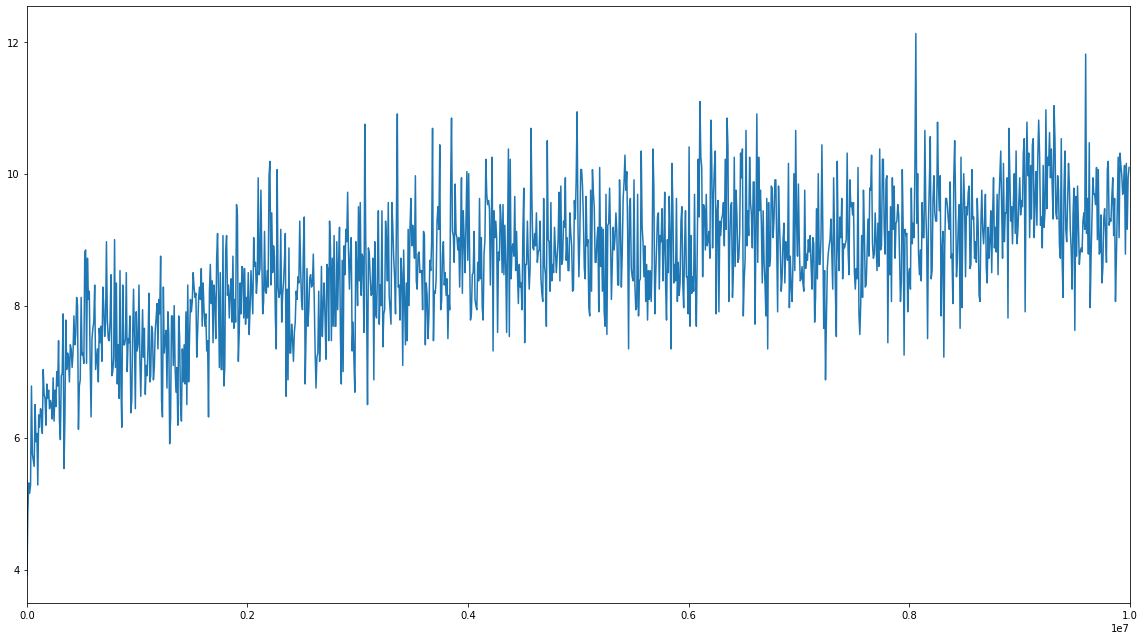

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
xIncrement = 0
x=[]
while xIncrement<total_steps:
  x.append(xIncrement)
  xIncrement=xIncrement+8192
y=np.load("data.npy")
plt.plot(x,y)
plt.xlim([0, total_steps])
plt.tight_layout() 
plt.show()

**Plot training and eval**

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
xIncrement = 0
x=[]
x2=[]
y2=[]
encoder = Encoder(3,512)
policyCheckpoint = Policy(encoder, 512, 15)
counter=0
while xIncrement<total_steps:
  if xIncrement%507904==0:
    x2.append(xIncrement)
    #evaluate
    policyCheckpoint.load_state_dict(torch.load(str("checkpointstar"+str(counter)+".pt")))
    policyCheckpoint.cuda()
    y2.append(evaluation(policyCheckpoint))
    counter=counter+1
  x.append(xIncrement)
  xIncrement=xIncrement+8192
x2.append(xIncrement)
#evaluate
policyCheckpoint.load_state_dict(torch.load(str("checkpointFinalstar.pt")))
policyCheckpoint.cuda()
y2.append(evaluation(policyCheckpoint))
y=np.load("data.npy")
fig, axs = plt.subplots(2)
axs[0].plot(x,y)
axs[1].plot(x2,y2)
plt.xlim([0, total_steps])
plt.tight_layout() 
plt.show()

NameError: ignored

<Figure size 1152x648 with 0 Axes>

**Evaluation function**

In [ ]:
def evaluation(policy):
  # Make evaluation environment
  eval_env = make_env(num_envs, env_name = 'starpilot',start_level=num_levels, num_levels=num_levels)
  obs = eval_env.reset()

  frames = []
  total_reward = []

  # Evaluate policy
  policy.eval()
  for _ in range(512):

    # Use policy
    action, log_prob, value = policy.act(obs)

    # Take step in environment
    obs, reward, done, info = eval_env.step(action)
    total_reward.append(torch.Tensor(reward))

  # Calculate average return
  total_reward = torch.stack(total_reward).sum(0).mean(0)
  print('Average return:', total_reward)
  return total_reward

**Generate graph from training text**

Step: 32768	Mean reward: 0.0625



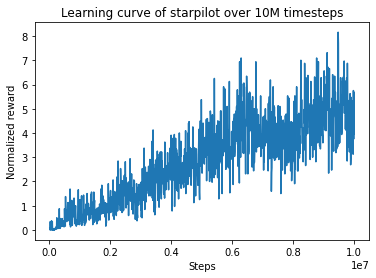

In [ ]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt

path_to_file = 'paste2.txt'
txt = open(path_to_file, 'r')
txt.readline()
txt.readline()
txt.readline()
line = txt.readline()
print(line)
X=[]
Y=[]
while line:
    if line == 'Completed training!':
        break
    splitLine = line.split()
    X.append(int(splitLine[1]))
    Y.append(float(splitLine[4]))
    line = txt.readline()


plt.plot(X,Y)
plt.title('Learning curve of starpilot over 10M timesteps')
plt.xlabel('Steps')
plt.ylabel('Normalized reward')
plt.show()